# Gender, age and length of career classificaiton

The aim of this part is to find out if it is possible to guess artists' gender and age based on their songs. Different approaches to problem will be tested: different classification algorithms, different combinations of datasets(music features, lyrics, genres).

In [1]:
import random
import ast
import scipy
import pickle
import collections
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, save_npz, load_npz
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA, TruncatedSVD, NMF
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, accuracy_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Input
from keras.utils import to_categorical
from keras.models import Model

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)

/home/marta/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load datasets

All datasets were created and saved in previous steps, so now they can be directly loaded and used without the need to compute everything from scratch each time.

There is still more than one file but they were created in such way, so that it would be easy to use only part of data (e.g. only music features without lyrics or combination of all available data) and vectors are stored in the same order, so the matrices have to be appended to each other.

In [2]:
#Dataset with averaged values of songs features for each artist

#sparse matrix with music genres in the same order as entries in artist_songs
genres_sparse = load_npz("data/genres_sparse.npz")
genres_sparse = genres_sparse.tocsr()

#sparse matrix with lyrics tfidf matrices for each artist (same order as in artist_songs)
lyrics_tfidf = load_npz("data/lyrics_tfidf.npz")

#dataframe with songs features for each artist
#need to change format of genres to numeric
artist_songs = pd.read_csv("data/artist_songs.csv")
artist_songs['gender'] = pd.to_numeric(artist_songs['gender'], errors='coerce')

#albums data
albums_info = pd.read_csv("data/albums_info.csv")
albums_info = albums_info.drop(columns=['Unnamed: 0'])

In [3]:
albums_info.head()

,artist_id,first_album,last_album,number_of_albums,titles
0,3XSyTI9ct70ZheMESAv2st,2010,2018,46,"['ディズニー マジカル・ワールド 〜ベスト・オブ・アラン・メンケン〜', 'ラプンツェル ..."
1,5BxcZnUcETSt90VlbsdugI,2017,2018,4,"['feelings', 'Melodies', 'Mission', 'On My Way']"
2,2jYHSJBXjusgmYdrNeaRmg,1994,2017,6,"['Uptown Groove', 'Laidback', 'The Way We Prai..."
3,3PvJOPfvRASwmEQTvNxEdK,2017,2017,1,['Dress Code']
4,3QYTmCDKIFaBgDCfwlZjdU,2014,2018,7,"['Songs from the Mud', 'In Bloom', ""I'm Danger..."


In [4]:
artist_songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739298 entries, 0 to 739297
Data columns (total 21 columns):
_id                 739297 non-null object
followers           739253 non-null float64
mb_id               739298 non-null object
popularity          738885 non-null float64
reduced_genres      738885 non-null object
gender              546464 non-null float64
type                546741 non-null object
begin_date_year     182520 non-null float64
danceability        369093 non-null float64
energy              369093 non-null float64
key                 369093 non-null float64
loudness            369093 non-null float64
mode                369093 non-null float64
speechiness         369093 non-null float64
acousticness        369093 non-null float64
instrumentalness    369093 non-null float64
liveness            369093 non-null float64
valence             369093 non-null float64
tempo               369093 non-null float64
duration_ms         369093 non-null float64
age          

## Feature analysis


In [52]:
music_features = artist_songs[['followers', 'popularity','danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'gender', 'age','type']]


music_features['lyrics'] = list(lyrics_tfidf)
music_features['genres'] = list(genres_sparse)

music_features = music_features[(music_features['gender']!=0)]

/home/marta/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/marta/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [6]:
music_features = music_features.dropna()
music_features.head()

,followers,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,gender,age,lyrics,genres
0,3752.0,61.0,0.5459,0.440100,6.4,-9.4249,0.8,0.14020,0.756500,3.180000e-07,0.15880,0.65750,2.0,38.0,,"(0, 417)\t1.0"
1,1361.0,29.0,0.6975,0.554100,5.8,-11.2578,0.4,0.04146,0.311739,7.196700e-01,0.09388,0.69470,2.0,58.0,,"(0, 201)\t1.0"
80,18.0,22.0,0.2168,0.197430,5.5,-17.0261,0.7,0.04539,0.911800,7.174316e-01,0.22717,0.08244,2.0,58.0,,
93,9.0,14.0,0.2470,0.076460,7.1,-22.4985,0.7,0.04495,0.955600,6.515000e-01,0.11944,0.11742,2.0,51.0,,
98,40.0,20.0,0.3998,0.054605,6.8,-27.5582,0.6,0.04613,0.994500,9.059000e-01,0.09894,0.21079,1.0,91.0,,


In [21]:
music_features.shape

(129682, 15)

In [7]:
X = music_features[['followers', 'popularity','danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence']]
y = music_features[['gender']].values

In [ ]:
g = sns.pairplot(music_features)

KeyboardInterrupt: 

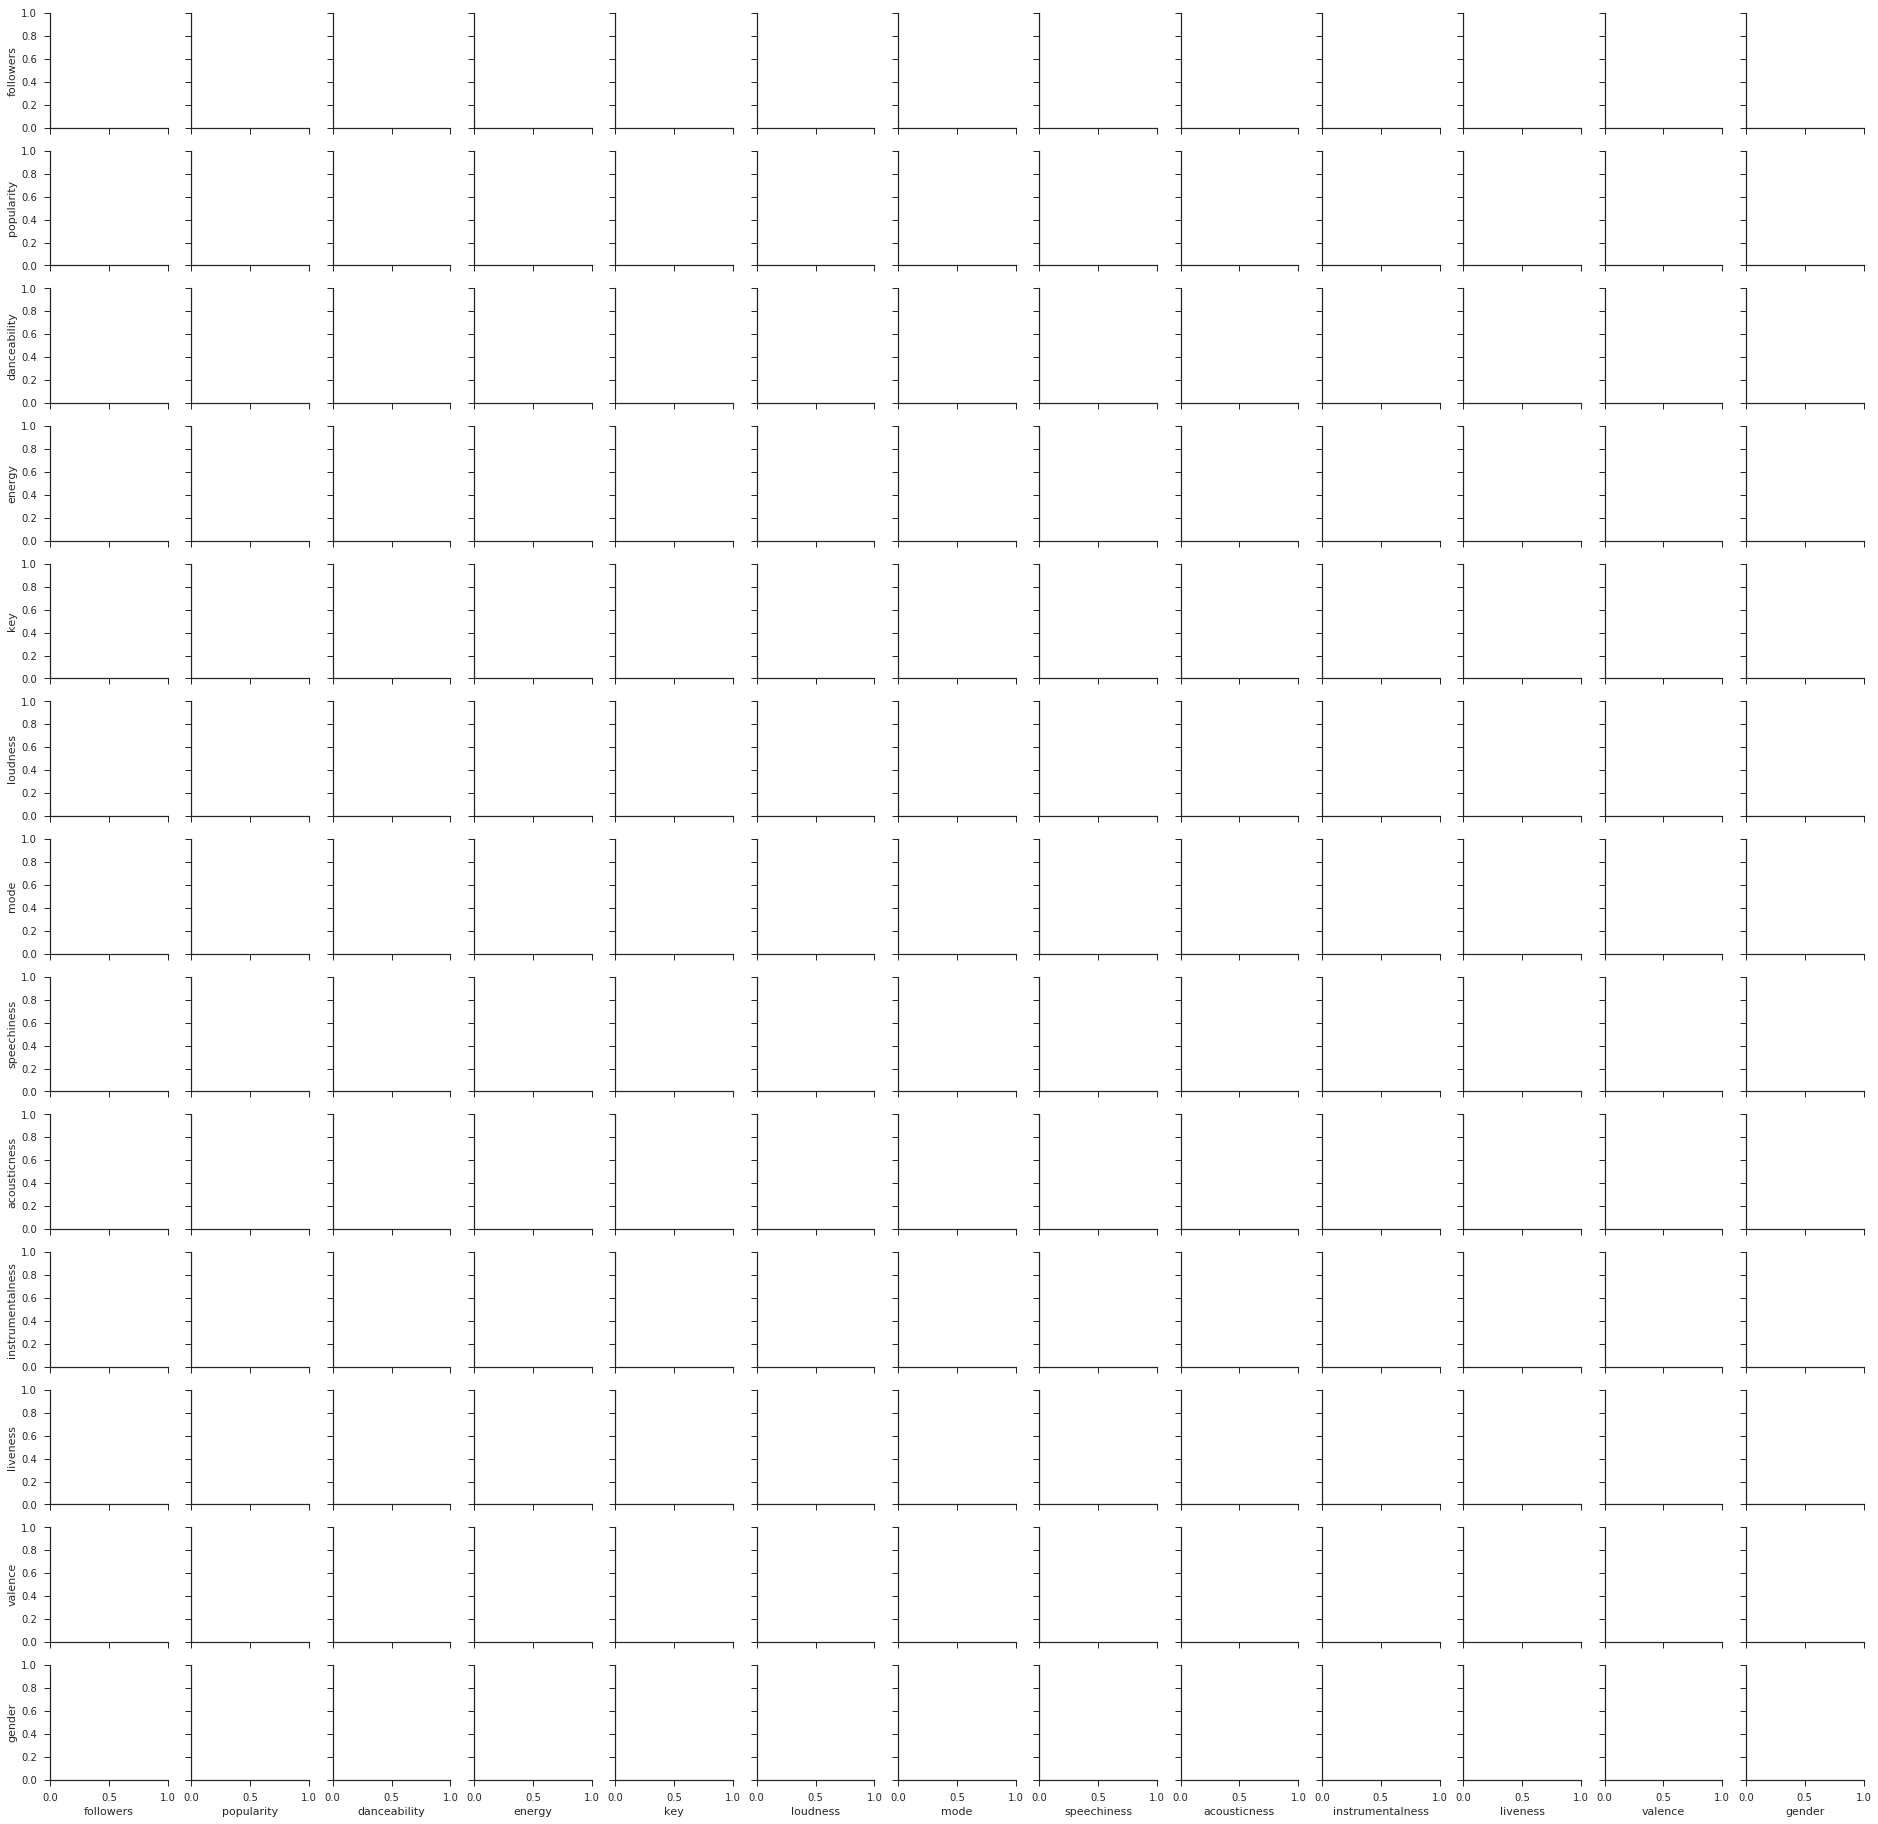

In [10]:
g = sns.pairplot(X, hue='gender')

### Dimensionality reduction and features selection for genres array and lyrics array

Use few different methods to reduce number of features. Currently it is 5000 for lyrics and 600 for genres. Then try some classificators using different representations of the data.

Methods for genres:  
 - chi2
 - PCA

Methods for lyrics:  
 - SVD (Latent Semantic Analysis)
 - Non-negative matrix factorization




In [7]:
genres = scipy.sparse.vstack(music_features['genres'])
lyrics = scipy.sparse.vstack(music_features['lyrics'])

In [15]:
k_best_10 = SelectKBest(chi2, 10)
genres_10 = k_best_10.fit_transform(scipy.sparse.vstack(music_features['genres']),y)

k_best_20 = SelectKBest(chi2, 20)
genres_20 = k_best_20.fit_transform(scipy.sparse.vstack(music_features['genres']),y)

k_best_60 = SelectKBest(chi2,60)
genres_60 = k_best_60.fit_transform(scipy.sparse.vstack(music_features['genres']), y)

In [15]:

pca = PCA(n_components=10)
genres_pca10 = pca.fit(genres.toarray()).transform(genres.toarray())

In [16]:


svd = TruncatedSVD(100)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

lyrics_lsa = lsa.fit_transform(lyrics)

In [17]:
nmf = NMF(n_components=100, random_state=0)
lyrics_nmf = nmf.fit_transform(lyrics)

# Classification

The aim of this part is to find out if it is possible to guess artists' gender and age based on their songs. Different approaches to problem will be tested: different classification algorithms, different combinations of datasets(music features, lyrics, genres).

## Gender classification
'dumb' random classification will be used to set the base values of classification accuracy. Accuracy of tested algorithms will be compared with this value.

In [29]:
#count frequencies of genders
gender_freq = music_features[['key', 'gender']].groupby('gender').count()
print(gender_freq)

           key
gender        
1.0      28566
2.0     101116


In [24]:
#there are four possible values of genders - to make it easier choose only 'Male' and 'Female' values
#unknown value is often asociated with groups, bands, etc.
dataset_genders = music_features.drop(music_features[(music_features.gender != 1) & (music_features.gender != 2)].index)
gender_freq = dataset_genders.groupby('gender').count()


In [30]:
female_number = gender_freq['key'][1]
male_number = gender_freq['key'][2]
total = female_number + male_number

f_ratio = female_number/total
m_ratio = male_number/total

In [31]:
print(f_ratio, m_ratio)

0.2202772936876359 0.7797227063123641


In [32]:
#function to 'predict' one of two values with biased frequency

# assume sum of bias is 1
def pred(bound):
    randNumb = random.random() # in [0,1)
    if randNumb <= bound:
        return 1
    else:
        return 2


In [33]:
#test the prediction function
female_n = 0
for i in range(0,1000):
    res = pred(f_ratio)
    if res == 1:
        female_n += 1
        
print("Female ratio is " + str(female_n/1000))

Female ratio is 0.21


In [37]:
correctly_classified = 0
for index, artist in dataset_genders.iterrows():
    predicted_gender = pred(f_ratio)
    if artist.gender == predicted_gender:
        correctly_classified += 1

In [38]:
baseline_accuracy = correctly_classified/len(dataset_genders)

In [39]:
print(baseline_accuracy)

0.6564519362748878


### Classification using only music features

In [8]:
data = music_features[['danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'gender']].dropna()
data = data[ (data.gender.isin([1,2]))]

In [9]:
data.shape

(129682, 11)

In [10]:
X = data[['danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence']].values
y = data[['gender']].values
y=y-1
print(X.shape, y.shape)

(129682, 10) (129682, 1)


In [11]:
y=y.astype('int')
y=y.reshape((y.shape[0],))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

In [13]:
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

#### Logistic Regression

In [46]:
parameters = {'C':[1,3,7,10], 'penalty': ['l2', 'l2'], 'class_weight': ['balanced',{0:4,1:1}, {0:10,1:1}]}
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'precision': 'precision', 'recall': 'recall',
            'tp' : make_scorer(tp), 'tn' : make_scorer(tn),
           'fp' : make_scorer(fp), 'fn' : make_scorer(fn)}
log_reg = LogisticRegression(max_iter=200,class_weight='balanced')
clf = GridSearchCV(log_reg, parameters,cv=10, scoring=scoring, refit = 'Accuracy', n_jobs=-1)
clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=200,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [1, 3, 7, 10], 'penalty': ['l2', 'l2'], 'class_weight': ['balanced', {0: 4, 1: 1}, {0: 10, 1: 1}]},
       pre_dispatch='2*n_jobs', refit='Accuracy',
       return_train_score='warn',
       scoring={'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'precision': 'precision', 'recall': 'recall', 'tp': make_scorer(tp), 'tn': make_scorer(tn), 'fp': make_scorer(fp), 'fn': make_scorer(fn)},
       verbose=0)

In [47]:
y_predicted = clf.predict(X_test)
class_report = classification_report(y_test, y_predicted)

In [48]:
print(class_report)

             precision    recall  f1-score   support

          0       0.33      0.67      0.45      8570
          1       0.87      0.62      0.73     30335

avg / total       0.75      0.63      0.66     38905



In [61]:
confusion_matrix(y_test, y_predicted)

array([[ 5740,  2830],
       [11467, 18868]])

In [62]:
print(accuracy_score(y_test, y_predicted))

0.6325151008867754


In [ ]:
pickle.dump(clf,open("results/logreg_cv_report.pkl", 'wb'))
pickle.dump(class_report, open("results/logreg_class_report", "wb"))

#### SVM

In [14]:
#parameters = {'C':[1,10], 'gamma': [1e-3, 'auto'],
#              'class_weight': ['balanced']}
parameters = {'C':[1], 'gamma': [ 'auto'],
              'class_weight': ['balanced']}
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'precision': 'precision', 'recall': 'recall',
            'tp' : make_scorer(tp), 'tn' : make_scorer(tn),
           'fp' : make_scorer(fp), 'fn' : make_scorer(fn)}

svm = SVC()
clf_svm = GridSearchCV(svm, parameters,cv=5, scoring=scoring, refit = 'Accuracy', n_jobs=-1)
clf_svm.fit(X_train, y_train)

Process ForkPoolWorker-24:
Process ForkPoolWorker-22:
Process ForkPoolWorker-23:
Process ForkPoolWorker-21:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/marta/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/marta/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/marta/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/marta/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/marta/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/marta/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/marta/anaconda3/lib/python3.6/mu

KeyboardInterrupt: 

In [ ]:
clf = SVC(class_weight='balanced')
clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
pickle.dump(clf,open("results/svm_cv_report.pkl", 'wb'))
pickle.dump(class_report, open("results/svm_class_report", "wb"))

#### Random Forest

In [50]:
parameters = {'n_estimators':[100,400, 600], 'max_features': ['auto', None],
             'class_weight': ['balanced', {0:10,1:1}]}

scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'precision': 'precision', 'recall': 'recall',
            'tp' : make_scorer(tp), 'tn' : make_scorer(tn),
           'fp' : make_scorer(fp), 'fn' : make_scorer(fn)}

dtc = RandomForestClassifier(class_weight='balanced')
clf_dtc = GridSearchCV(dtc, parameters,cv=5, scoring=scoring, refit = 'Accuracy', n_jobs=12)
clf_dtc.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=12,
       param_grid={'n_estimators': [100, 400, 600], 'max_features': ['auto', None], 'class_weight': ['balanced', {0: 10, 1: 1}]},
       pre_dispatch='2*n_jobs', refit='Accuracy',
       return_train_score='warn',
       scoring={'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'precision': 'precision', 'recall': 'recall', 'tp': make_scorer(tp), 'tn': make_scorer(tn), 'fp': make_scorer(fp), 'fn': make_scorer(fn)},
       verbose=0)

In [ ]:
clf_dtc.cv_results_

In [51]:
y_pred_dtc = clf_dtc.predict(X_test) 

In [52]:
print(classification_report(y_test, y_pred_dtc))

             precision    recall  f1-score   support

          0       0.57      0.13      0.21      8570
          1       0.80      0.97      0.88     30335

avg / total       0.75      0.79      0.73     38905



In [59]:
print(confusion_matrix(y_test,y_pred_dtc))

[[ 1121  7449]
 [  847 29488]]


In [60]:
print(accuracy_score(y_test, y_pred_dtc))

0.786762626911708


In [54]:
class_report = classification_report(y_test, y_pred_dtc)
pickle.dump(clf_dtc,open("results/randomforest_cv_report.pkl", 'wb'))
pickle.dump(class_report, open("results/randomforest_class_report", "wb"))

#### Neural Network

In [15]:
y_train_c = to_categorical(y_train)
y_test_c = to_categorical(y_test)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [25]:

inp = Input(shape=(X_train.shape[1],))
l0 = Dropout(0.2)(inp)
l1 = Dense(128, input_dim=X_train.shape[1], activation ='relu')(inp)
l2 = Dropout(0.2)(l1)
l3 = Dense(92, activation = 'relu')(l2)
l4 = Dense(2, activation='sigmoid')(l3)

model = Model(inp, l4)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
#history = model.fit(X_train,y_train_c, validation_data=(X_test,y_test_c), epochs=50, class_weight={0:1,1:10}, batch_size=128)
history = model.fit(X_train,y_train_c, validation_split=0.4, epochs=50, class_weight={0:10,1:1} batch_size=128)

Train on 54466 samples, validate on 36311 samples
Epoch 1/50
54466/54466 [==============================] - 2s 31us/step - loss: 0.4664 - acc: 0.7870 - val_loss: 0.4709 - val_acc: 0.7829
Epoch 2/50
54466/54466 [==============================] - 2s 30us/step - loss: 0.4658 - acc: 0.7868 - val_loss: 0.4750 - val_acc: 0.7826
Epoch 3/50
54466/54466 [==============================] - 2s 30us/step - loss: 0.4665 - acc: 0.7862 - val_loss: 0.4705 - val_acc: 0.7828
Epoch 4/50
54466/54466 [==============================] - 2s 31us/step - loss: 0.4658 - acc: 0.7872 - val_loss: 0.4716 - val_acc: 0.7833
Epoch 5/50
54466/54466 [==============================] - 2s 30us/step - loss: 0.4666 - acc: 0.7870 - val_loss: 0.4726 - val_acc: 0.7826
Epoch 6/50
54466/54466 [==============================] - 2s 32us/step - loss: 0.4658 - acc: 0.7872 - val_loss: 0.4709 - val_acc: 0.7836
Epoch 7/50
54466/54466 [==============================] - 2s 30us/step - loss: 0.4666 - acc: 0.7857 - val_loss: 0.4707 - val_acc

In [32]:
history.params

{'batch_size': 128,
 'do_validation': True,
 'epochs': 50,
 'metrics': ['loss', 'acc', 'val_loss', 'val_acc'],
 'samples': 54466,
 'steps': None,
 'verbose': 1}

In [40]:
y_pred = model.predict(X_test)

y_pred_res = y_pred.argmax(axis=1)

In [41]:
y_pred_res

array([1, 1, 1, ..., 1, 1, 1])

In [42]:
print(classification_report(y_test, y_pred_res))

             precision    recall  f1-score   support

          0       0.57      0.12      0.20      8570
          1       0.80      0.97      0.88     30335

avg / total       0.75      0.79      0.73     38905



In [43]:
print(accuracy_score(y_test, y_pred_res))

0.7866084050893202


In [44]:
print(confusion_matrix(y_test,y_pred_res))

[[ 1065  7505]
 [  797 29538]]


### Classification using combination of features

In [5]:
music_features.columns

Index(['followers', 'popularity', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'gender', 'lyrics', 'genres'],
      dtype='object')

In [51]:
data = music_features[['danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'gender']].dropna()
data = data[ (data.gender.isin([1,2]))]

In [52]:
X = data[['danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence']].values
y = data[['gender']].values
y=y-1
print(X.shape, y.shape)

(129682, 10) (129682, 1)


In [53]:
y=y.astype('int')
y=y.reshape((y.shape[0],))

In [54]:
#X_gen = np.concatenate((X,genres.toarray()), axis=1)
X_gen_lyr = np.concatenate((X, lyrics.toarray()), axis=1)
print(X_gen_lyr.shape)
X_train, X_test, y_train, y_test = train_test_split(X_gen_lyr, y, test_size=0.3, random_state=42,stratify=y)


(129682, 5010)


In [12]:
X = []
X_gen = []
X_gen_lyr = []
albums_info = []
artist_songs =[]
data = []
music_features = []

In [16]:
import os

In [17]:
os.environ['JOBLIB_TEMP_FOLDER'] = "/home/marta"

#### Logistic regression

In [27]:
#parameters = {'C':[1,7,10], 'class_weight': ['balanced',{0:4,1:1}, {0:10,1:1}]}
parameters = {'C' :[1]}
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'precision': 'precision', 'recall': 'recall',
            'tp' : make_scorer(tp), 'tn' : make_scorer(tn),
           'fp' : make_scorer(fp), 'fn' : make_scorer(fn)}
log_reg_all = LogisticRegression(max_iter=200,class_weight='balanced')
clf_all = GridSearchCV(log_reg_all, parameters,cv=3, scoring=scoring, refit = 'Accuracy', n_jobs=12)
clf_all.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=200,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=12, param_grid={'C': [1]},
       pre_dispatch='2*n_jobs', refit='Accuracy',
       return_train_score='warn',
       scoring={'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'precision': 'precision', 'recall': 'recall', 'tp': make_scorer(tp), 'tn': make_scorer(tn), 'fp': make_scorer(fp), 'fn': make_scorer(fn)},
       verbose=0)

In [28]:
y_pred_lr_all = clf_all.predict(X_test)

In [29]:
print(classification_report(y_test, y_pred_lr_all))

             precision    recall  f1-score   support

          0       0.34      0.67      0.45      8570
          1       0.87      0.63      0.73     30335

avg / total       0.75      0.64      0.67     38905



In [30]:
confusion_matrix(y_test,y_pred_lr_all)

array([[ 5727,  2843],
       [11142, 19193]])

In [33]:
print(accuracy_score(y_test, y_pred_lr_all))

0.6405346356509446


#### Random forest

In [ ]:
#parameters = {'n_estimators':[400,600],  'max_features': ['auto', 'log2', ],
#             'class_weight': ['balanced']}
parameters = {'n_estimators':[600],  'max_features': ['auto' ],
             'class_weight': ['balanced']}

scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'precision': 'precision', 'recall': 'recall',
            'tp' : make_scorer(tp), 'tn' : make_scorer(tn),
           'fp' : make_scorer(fp), 'fn' : make_scorer(fn)}

dtc_all = RandomForestClassifier(class_weight='balanced')
clf_dtc_all = GridSearchCV(dtc_all, parameters,cv=3, scoring=scoring, refit = 'Accuracy', n_jobs=12)
clf_dtc_all.fit(X_train, y_train)


In [ ]:
y_pred_dtc_all = clf_dtc_all.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_dtc_all))

In [ ]:
confusion_matrix(y_test, y_pred_dtc_all)

In [ ]:
class_report = classification_report(y_test, y_pred_dtc_all)
pickle.dump(clf_dtc_all,open("results/randomforest_all_cv_report.pkl", 'wb'))
pickle.dump(class_report, open("results/randomforest_all_class_report", "wb"))

In [49]:
clf_dtc_all = pickle.load(open("results/randomforest_all_cv_report.pkl", 'rb'))
#report = pickle.load(open("results/randomforest_all_class_report", "rb"))

In [55]:
y_pred_dtc_all = clf_dtc_all.predict(X_test)
print(classification_report(y_test, y_pred_dtc_all))
confusion_matrix(y_test, y_pred_dtc_all)

             precision    recall  f1-score   support

          0       0.39      0.54      0.45      8570
          1       0.85      0.76      0.81     30335

avg / total       0.75      0.71      0.73     38905



array([[ 4588,  3982],
       [ 7151, 23184]])

In [56]:
print(accuracy_score(y_test, y_pred_dtc_all))

0.7138414085593111


#### Neural network

In [57]:
y_train_c = to_categorical(y_train)
y_test_c = to_categorical(y_test)

In [58]:
y_test_c

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [59]:
np.random.seed(10)

In [60]:
inp = Input(shape=(X_train.shape[1],))
l0 = Dropout(0.1)(inp)
l1 = Dense(128, input_dim=X_train.shape[1], activation ='relu')(l0)
l2 = Dropout(0.2)(l1)
l3 = Dense(128, activation = 'relu')(l2)
l4 = Dense(2, activation='sigmoid')(l3)

model = Model(inp, l4)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [61]:
history = model.fit(X_train,y_train_c, validation_data=(X_test,y_test_c), class_weight={0:4,1:1},epochs=50, batch_size=64)

Train on 90777 samples, validate on 38905 samples
Epoch 1/50
90777/90777 [==============================] - 20s 223us/step - loss: 1.0795 - acc: 0.5451 - val_loss: 0.6977 - val_acc: 0.5229
Epoch 2/50
90777/90777 [==============================] - 19s 205us/step - loss: 1.0559 - acc: 0.5752 - val_loss: 0.6584 - val_acc: 0.6177
Epoch 3/50
90777/90777 [==============================] - 19s 204us/step - loss: 1.0461 - acc: 0.5810 - val_loss: 0.6686 - val_acc: 0.5967
Epoch 4/50
90777/90777 [==============================] - 19s 204us/step - loss: 1.0394 - acc: 0.5821 - val_loss: 0.6851 - val_acc: 0.5518
Epoch 5/50
90777/90777 [==============================] - 19s 206us/step - loss: 1.0335 - acc: 0.5793 - val_loss: 0.6414 - val_acc: 0.6016
Epoch 6/50
90777/90777 [==============================] - 18s 199us/step - loss: 1.0278 - acc: 0.5787 - val_loss: 0.6149 - val_acc: 0.6251
Epoch 7/50
90777/90777 [==============================] - 18s 199us/step - loss: 1.0266 - acc: 0.5793 - val_loss: 0.

In [62]:
y_pred = model.predict(X_test)

In [63]:
y_pred_res = y_pred.argmax(axis=1)

In [64]:
print(classification_report(y_test, y_pred_res))

             precision    recall  f1-score   support

          0       0.34      0.70      0.46      8570
          1       0.88      0.62      0.73     30335

avg / total       0.76      0.64      0.67     38905



In [65]:
print(accuracy_score(y_test,y_pred_res))

0.640071970183781


### Classification using reduced genres and lyrics

In [12]:
data = music_features[['danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'gender']].dropna()
data = data[ (data.gender.isin([1,2]))]

In [13]:
data.shape

(129682, 11)

In [16]:
X = data[['danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence']].values
y = data[['gender']].values
y=y-1
print(X.shape, y.shape)

(129682, 10) (129682, 1)


Create datasets with reduced genres and lyrics

In [17]:
y=y.astype('int')
y=y.reshape((y.shape[0],))

In [28]:
parameters = {'n_estimators':[400], 'max_features': ['auto'],
             'class_weight': ['balanced']}

scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'precision': 'precision', 'recall': 'recall',
            'tp' : make_scorer(tp), 'tn' : make_scorer(tn),
           'fp' : make_scorer(fp), 'fn' : make_scorer(fn)}

In [26]:
#genres_10, lyrics_lsa
X_gen = np.concatenate((X,genres_10.toarray()), axis=1)
X_gen_lyr = np.concatenate((X_gen, lyrics_lsa), axis=1)
print(X_gen_lyr.shape)
X_train, X_test, y_train, y_test = train_test_split(X_gen_lyr, y, test_size=0.3, random_state=42,stratify=y)

dtc = RandomForestClassifier()
clf_dtc = GridSearchCV(dtc, parameters,cv=5, scoring=scoring, refit = 'Accuracy', n_jobs=12)
clf_dtc.fit(X_train, y_train)

y_pred = clf_dtc.predict(X_test)

class_report = classification_report(y_test, y_pred)
pickle.dump(clf_dtc,open("results/rf_gen10_lsa_model.pkl", 'wb'))
pickle.dump(class_report, open("results/rf_gen10_lsa_report", "wb"))

(129682, 120)


In [27]:
print(class_report)
print(confusion_matrix(y_test, y_pred))


             precision    recall  f1-score   support

          0       0.61      0.11      0.19      8570
          1       0.80      0.98      0.88     30335

avg / total       0.75      0.79      0.73     38905

[[  937  7633]
 [  601 29734]]


In [ ]:
#genres_20, lyrics_lsa
X_gen = np.concatenate((X,genres_20.toarray()), axis=1)
X_gen_lyr = np.concatenate((X_gen, lyrics_lsa), axis=1)
print(X_gen_lyr.shape)
X_train, X_test, y_train, y_test = train_test_split(X_gen_lyr, y, test_size=0.3, random_state=42,stratify=y)

dtc = RandomForestClassifier()
clf_dtc = GridSearchCV(dtc, parameters,cv=5, scoring=scoring, refit = 'Accuracy', n_jobs=12)
clf_dtc.fit(X_train, y_train)

y_pred = clf_dtc.predict(X_test)

class_report = classification_report(y_test, y_pred)
pickle.dump(clf_dtc,open("results/rf_gen20_lsa_model.pkl", 'wb'))
pickle.dump(class_report, open("results/rf_gen20_lsa_report", "wb"))

print(class_report)
print(confusion_matrix(y_test, y_pred))

In [ ]:
#genres_60, lyrics_lsa
X_gen = np.concatenate((X,genres_60.toarray()), axis=1)
X_gen_lyr = np.concatenate((X_gen, lyrics_lsa), axis=1)
print(X_gen_lyr.shape)
X_train, X_test, y_train, y_test = train_test_split(X_gen_lyr, y, test_size=0.3, random_state=42,stratify=y)

dtc = RandomForestClassifier()
clf_dtc = GridSearchCV(dtc, parameters,cv=5, scoring=scoring, refit = 'Accuracy', n_jobs=12)
clf_dtc.fit(X_train, y_train)

y_pred = clf_dtc.predict(X_test)

class_report = classification_report(y_test, y_pred)
pickle.dump(clf_dtc,open("results/rf_gen60_lsa_model.pkl", 'wb'))
pickle.dump(class_report, open("results/rf_gen60_lsa_report", "wb"))

print(class_report)
print(confusion_matrix(y_test, y_pred))

In [ ]:
clf_dtc = 

In [29]:
#genres_pca10, lyrics_lsa
X_gen = np.concatenate((X,genres_pca10), axis=1)
X_gen_lyr = np.concatenate((X_gen, lyrics_lsa), axis=1)
print(X_gen_lyr.shape)
X_train, X_test, y_train, y_test = train_test_split(X_gen_lyr, y, test_size=0.3, random_state=42,stratify=y)

dtc = RandomForestClassifier()
clf_dtc = GridSearchCV(dtc, parameters,cv=5, scoring=scoring, refit = 'Accuracy', n_jobs=12)
clf_dtc.fit(X_train, y_train)

y_pred = clf_dtc.predict(X_test)

class_report = classification_report(y_test, y_pred)
pickle.dump(clf_dtc,open("results/rf_genpca10_lsa_model.pkl", 'wb'))
pickle.dump(class_report, open("results/rf_genpca10_lsa_report", "wb"))

print(class_report)
print(confusion_matrix(y_test, y_pred))

(129682, 120)
             precision    recall  f1-score   support

          0       0.61      0.12      0.20      8570
          1       0.80      0.98      0.88     30335

avg / total       0.76      0.79      0.73     38905

[[ 1045  7525]
 [  670 29665]]


In [30]:
#genres_10, lyrics_nmf
X_gen = np.concatenate((X,genres_10.toarray()), axis=1)
X_gen_lyr = np.concatenate((X_gen, lyrics_nmf), axis=1)
print(X_gen_lyr.shape)
X_train, X_test, y_train, y_test = train_test_split(X_gen_lyr, y, test_size=0.3, random_state=42,stratify=y)

dtc = RandomForestClassifier()
clf_dtc = GridSearchCV(dtc, parameters,cv=5, scoring=scoring, refit = 'Accuracy', n_jobs=12)
clf_dtc.fit(X_train, y_train)

y_pred = clf_dtc.predict(X_test)

class_report = classification_report(y_test, y_pred)
pickle.dump(clf_dtc,open("results/rf_gen10_nmf_model.pkl", 'wb'))
pickle.dump(class_report, open("results/rf_gen10_nmf_report", "wb"))

print(class_report)
print(confusion_matrix(y_test, y_pred))

(129682, 120)
             precision    recall  f1-score   support

          0       0.62      0.11      0.19      8570
          1       0.80      0.98      0.88     30335

avg / total       0.76      0.79      0.73     38905

[[  969  7601]
 [  605 29730]]


In [ ]:
#genres_20, lyrics_nmf
X_gen = np.concatenate((X,genres_20.toarray()), axis=1)
X_gen_lyr = np.concatenate((X_gen, lyrics_nmf), axis=1)
print(X_gen_lyr.shape)
X_train, X_test, y_train, y_test = train_test_split(X_gen_lyr, y, test_size=0.3, random_state=42,stratify=y)

dtc = RandomForestClassifier()
clf_dtc = GridSearchCV(dtc, parameters,cv=5, scoring=scoring, refit = 'Accuracy', n_jobs=12)
clf_dtc.fit(X_train, y_train)

y_pred = clf_dtc.predict(X_test)

class_report = classification_report(y_test, y_pred)
pickle.dump(clf_dtc,open("results/rf_gen20_nmf_model.pkl", 'wb'))
pickle.dump(class_report, open("results/rf_gen20_nmf_report", "wb"))

print(class_report)
print(confusion_matrix(y_test, y_pred))

In [31]:
#genres_60, lyrics_nmf
X_gen = np.concatenate((X,genres_60.toarray()), axis=1)
X_gen_lyr = np.concatenate((X_gen, lyrics_nmf), axis=1)
print(X_gen_lyr.shape)
X_train, X_test, y_train, y_test = train_test_split(X_gen_lyr, y, test_size=0.3, random_state=42,stratify=y)

dtc = RandomForestClassifier()
clf_dtc = GridSearchCV(dtc, parameters,cv=5, scoring=scoring, refit = 'Accuracy', n_jobs=12)
clf_dtc.fit(X_train, y_train)

y_pred = clf_dtc.predict(X_test)

class_report = classification_report(y_test, y_pred)
pickle.dump(clf_dtc,open("results/rf_gen60_nmf_model.pkl", 'wb'))
pickle.dump(class_report, open("results/rf_gen60_nmf_report", "wb"))

print(class_report)
print(confusion_matrix(y_test, y_pred))

(129682, 170)
             precision    recall  f1-score   support

          0       0.62      0.11      0.19      8570
          1       0.80      0.98      0.88     30335

avg / total       0.76      0.79      0.73     38905

[[  954  7616]
 [  579 29756]]


In [32]:
#genres_pca10, lyrics_nmf
X_gen = np.concatenate((X,genres_pca10), axis=1)
X_gen_lyr = np.concatenate((X_gen, lyrics_nmf), axis=1)
print(X_gen_lyr.shape)
X_train, X_test, y_train, y_test = train_test_split(X_gen_lyr, y, test_size=0.3, random_state=42,stratify=y)

dtc = RandomForestClassifier()
clf_dtc = GridSearchCV(dtc, parameters,cv=5, scoring=scoring, refit = 'Accuracy', n_jobs=12)
clf_dtc.fit(X_train, y_train)

y_pred = clf_dtc.predict(X_test)

class_report = classification_report(y_test, y_pred)
pickle.dump(clf_dtc,open("results/rf_genpca10_nmf_model.pkl", 'wb'))
pickle.dump(class_report, open("results/rf_genpca10_nmf_report", "wb"))

print(class_report)
print(confusion_matrix(y_test, y_pred))

(129682, 120)
             precision    recall  f1-score   support

          0       0.61      0.12      0.20      8570
          1       0.80      0.98      0.88     30335

avg / total       0.76      0.79      0.73     38905

[[ 1026  7544]
 [  654 29681]]


In [33]:

collections.Counter(y_train)

Counter({0: 19996, 1: 70781})

## Age classification

The idea is to split artist by age to three/four groups of similar size and then create classificators for predicting the age.

In [74]:
music_features.columns


Index(['followers', 'popularity', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'gender', 'age', 'type', 'lyrics', 'genres'],
      dtype='object')

In [75]:
data_all = music_features[['danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness','type', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'age', 'gender', 'lyrics']].dropna()


In [76]:
data_all.head()

,danceability,energy,key,loudness,mode,speechiness,type,acousticness,instrumentalness,liveness,valence,age,gender,lyrics
0,0.5459,0.440100,6.4,-9.4249,0.8,0.14020,Person,0.756500,3.180000e-07,0.15880,0.65750,38.0,2.0,
1,0.6975,0.554100,5.8,-11.2578,0.4,0.04146,Person,0.311739,7.196700e-01,0.09388,0.69470,58.0,2.0,
80,0.2168,0.197430,5.5,-17.0261,0.7,0.04539,Person,0.911800,7.174316e-01,0.22717,0.08244,58.0,2.0,
93,0.2470,0.076460,7.1,-22.4985,0.7,0.04495,Person,0.955600,6.515000e-01,0.11944,0.11742,51.0,2.0,
98,0.3998,0.054605,6.8,-27.5582,0.6,0.04613,Person,0.994500,9.059000e-01,0.09894,0.21079,91.0,1.0,


In [77]:
data_all.loc[data_all['type']=='Group','age'] = data_all[data_all['type']=='Group']['age']+20

In [78]:
data_all.loc[data_all['age']<0,'age'] = 0

In [79]:
data_all.head()

,danceability,energy,key,loudness,mode,speechiness,type,acousticness,instrumentalness,liveness,valence,age,gender,lyrics
0,0.5459,0.440100,6.4,-9.4249,0.8,0.14020,Person,0.756500,3.180000e-07,0.15880,0.65750,38.0,2.0,
1,0.6975,0.554100,5.8,-11.2578,0.4,0.04146,Person,0.311739,7.196700e-01,0.09388,0.69470,58.0,2.0,
80,0.2168,0.197430,5.5,-17.0261,0.7,0.04539,Person,0.911800,7.174316e-01,0.22717,0.08244,58.0,2.0,
93,0.2470,0.076460,7.1,-22.4985,0.7,0.04495,Person,0.955600,6.515000e-01,0.11944,0.11742,51.0,2.0,
98,0.3998,0.054605,6.8,-27.5582,0.6,0.04613,Person,0.994500,9.059000e-01,0.09894,0.21079,91.0,1.0,


(0, 100)

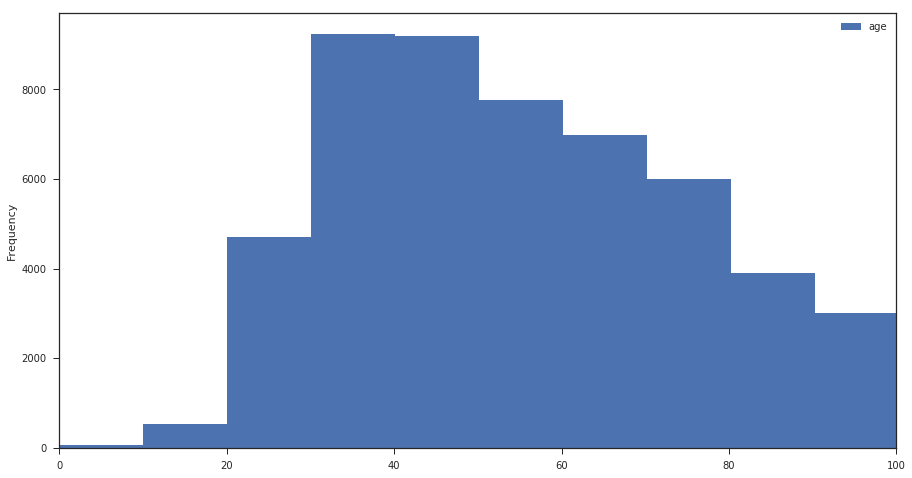

In [80]:
##create buckets for age
data_all.plot.hist(y='age', bins = 200, figsize=(15,8))
plt.xlim(0,100)

In [81]:
sorted_data = data_all.sort_values('age')

In [82]:
sorted_data.head()

,danceability,energy,key,loudness,mode,speechiness,type,acousticness,instrumentalness,liveness,valence,age,gender,lyrics
732971,0.338333,0.729667,4.000000,-9.75900,0.333333,0.090233,Person,0.000050,0.804333,0.278333,0.119200,0.0,2.0,
490437,0.658200,0.608800,6.400000,-8.27000,1.000000,0.054740,Character,0.281600,0.000984,0.110420,0.601600,1.0,2.0,
713282,0.658700,0.532400,4.100000,-9.02960,0.600000,0.111910,Character,0.674600,0.453103,0.178720,0.398800,1.0,1.0,
650467,0.541000,0.906250,9.000000,-3.11625,0.750000,0.104100,Character,0.018019,0.000047,0.227000,0.526750,1.0,1.0,
739219,0.493000,0.732500,7.833333,-7.23350,0.333333,0.043033,Character,0.006761,0.163321,0.098700,0.379667,1.0,2.0,


In [83]:
sorted_data.shape

(57943, 14)

In [84]:
57943/4

14485.75

57943/4 = 14485 - each bucket will have  about 28329 entries

In [85]:
print(sorted_data.iloc[14485].age)
print(sorted_data.iloc[2*14485].age)
print(sorted_data.iloc[3*14485].age)

40.0
57.0
78.0


four age gropus will be created with following bounds:  
0: 0-40  
1: 40-57  
2: 57-78  
3: 78-...  

In [86]:
def set_age(age):
    if age<40:
        return 0
    if age>=40 and age<57:
        return 1
    if age>=57 and age <78:
        return 2
    return 3

In [87]:
data_all['age_group'] = data_all['age'].apply(set_age)

In [88]:
X = data_all[['danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence']].values
y = data_all[['age_group']].values

print(X.shape, y.shape)
  

(57943, 10) (57943, 1)


In [89]:
#use dimensionality reduction on lyrics to speed up algorithm

lyrics = scipy.sparse.vstack(data_all['lyrics'])

svd = TruncatedSVD(100)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

lyrics_lsa = lsa.fit_transform(lyrics)

X = np.concatenate((X,lyrics_lsa), axis=1)
    

In [90]:

y=y.astype('int')

lb = preprocessing.LabelBinarizer()
y = lb.fit_transform(y)
#y=y.reshape((y.shape[0],))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

In [72]:
y


array([[1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       ...,
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0]], dtype=int64)

### Random Forest

In [ ]:
parameters = {'n_estimators':[100,600], 'max_features': ['auto', 'log2' ]}

scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score),
           'recall': 'recall',
            'tp' : make_scorer(tp), 'tn' : make_scorer(tn),
           'fp' : make_scorer(fp), 'fn' : make_scorer(fn)}

dtc_all = RandomForestClassifier(class_weight='balanced')
clf_dtc_all = GridSearchCV(dtc_all, parameters,cv=5, scoring=scoring, refit = 'Accuracy', n_jobs=-1)
clf_dtc_all.fit(X_train, y_train)


In [91]:
rfc =  RandomForestClassifier(n_estimators=600)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [92]:
y_pred = rfc.predict(X_test)

In [93]:
y_pred

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [94]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.69      0.40      0.51      4006
          1       0.68      0.07      0.12      4492
          2       0.64      0.06      0.12      4324
          3       0.75      0.44      0.56      4561

avg / total       0.69      0.24      0.32     17383



In [95]:
confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

array([[3821,   93,   17,   75],
       [3932,  296,   67,  197],
       [3593,   42,  274,  415],
       [2468,    7,   67, 2019]])

## Career length prediction

In this part the career lenght will be predicted. Again, different configurations and algorithms will be tried to find the best output. Main approaches will be to try regression algorithms (use career length as target variable) and classification (create few bins with artists based on their career length)

### Ridge regression

In [7]:
#consider only artist with last album older than 4 years
old_albums = albums_info[albums_info['last_album'] < 2012]

In [8]:
data = artist_songs[['_id','danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'gender']].dropna()
data = data.merge(old_albums,how='left',left_on='_id', right_on='artist_id')

In [9]:
data = data.dropna()

In [10]:
data['duration'] = data['last_album']-data['first_album']
data = data[data['duration']<100]

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33210 entries, 3 to 286053
Data columns (total 18 columns):
_id                 33210 non-null object
danceability        33210 non-null float64
energy              33210 non-null float64
key                 33210 non-null float64
loudness            33210 non-null float64
mode                33210 non-null float64
speechiness         33210 non-null float64
acousticness        33210 non-null float64
instrumentalness    33210 non-null float64
liveness            33210 non-null float64
valence             33210 non-null float64
gender              33210 non-null float64
artist_id           33210 non-null object
first_album         33210 non-null float64
last_album          33210 non-null float64
number_of_albums    33210 non-null float64
titles              33210 non-null object
duration            33210 non-null float64
dtypes: float64(15), object(3)
memory usage: 4.8+ MB


In [45]:
data.head()

,_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,gender,artist_id,first_album,last_album,number_of_albums,titles,duration
3,0NESoZVYcw7JFJ34gCyTfn,0.246600,0.6856,5.000000,-14.942300,0.700000,0.10650,0.091079,0.752170,0.170050,0.200960,0.0,0NESoZVYcw7JFJ34gCyTfn,1994.0,1994.0,1.0,"['To the Depths, in Degradation']",0.0
199145,7CEQvBZQV8ZISDZ3cfGUDu,0.342857,0.8610,4.428571,-6.337571,0.857143,0.13230,0.011399,0.000019,0.249086,0.476571,0.0,7CEQvBZQV8ZISDZ3cfGUDu,2000.0,2000.0,1.0,['Split'],0.0
199087,5ntynWGZQKYBOuMtj7EAbe,0.411500,0.1107,0.000000,-17.240000,1.000000,0.03165,0.980500,0.808500,0.099100,0.365500,2.0,5ntynWGZQKYBOuMtj7EAbe,2000.0,2000.0,1.0,"['Bach: Concertos for 2, 3 and 4 Organs, BWV 1...",0.0
199078,5ffpHBFYj8jRnfGcKCOn9v,0.409000,0.3760,7.000000,-16.797000,1.000000,0.04960,0.354000,0.397000,0.261000,0.218000,1.0,5ffpHBFYj8jRnfGcKCOn9v,1998.0,1998.0,2.0,"['Footsteps in the Sand', ""Who's Serious""]",0.0
199060,7KqDW4VN5zPPngxw5dVnXl,0.620000,0.4270,3.000000,-14.872000,1.000000,0.54400,0.879000,0.000005,0.686000,0.820000,2.0,7KqDW4VN5zPPngxw5dVnXl,2007.0,2007.0,1.0,['My Fair Lady (2001 London Cast Recording)'],0.0


In [12]:
X = data[['danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'gender']].values
y = data[['duration']].values

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

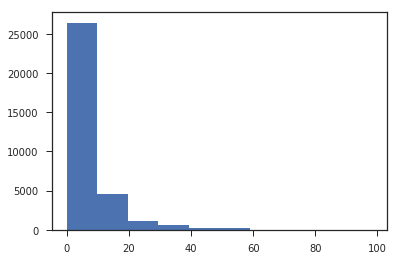

In [14]:
plt.hist(y, bins=10)
plt.show()

In [19]:
reg = linear_model.Ridge(alpha = .5, normalize=True)
reg.fit(X_train,y_train)


Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

In [20]:
y_pred = reg.predict(X_test)

In [33]:
y_pred = y_pred.astype(int)

(array([   3.,  147., 1618., 2531., 1863., 1477., 1068.,  778.,  386.,
          92.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <a list of 10 Patch objects>)

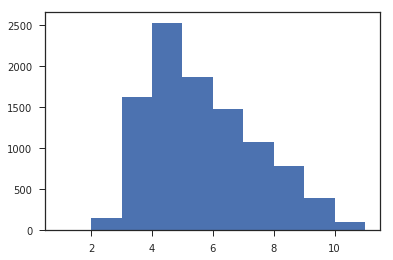

In [36]:
plt.hist(y_pred, bins=10)

In [34]:

metrics.mean_squared_error(y_test, y_pred)

76.62701997390344

In [35]:
metrics.mean_absolute_error(y_test,y_pred)

5.681923115527452

### Neural network

In [25]:
y_train_nn = y_train.ravel()

In [26]:
nn = MLPRegressor(
    hidden_layer_sizes=(20,2),  activation='relu', solver='adam', alpha=0.001, batch_size='auto',
    learning_rate='constant', learning_rate_init=0.01, power_t=0.5, max_iter=2000, shuffle=True,
    random_state=9, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
    early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

n = nn.fit(X_train, y_train_nn)

In [27]:
pred = nn.predict(X_test)

In [28]:
metrics.mean_squared_error(pred, y_test)

80.56095613874415

In [29]:
metrics.mean_absolute_error(pred, y_test)

6.048412374358432

Mean absolute error tells us how much predicted value differs from original one. The value 6 means that, on average the career length was 6 years shorter or 6 years longer than it really was.

### Random Forest

In [47]:
#decide on the split on bins
num = data.shape[0]
split_value = int(num/3)

In [49]:
data = data.sort_values(by = 'duration')
age1 = data.iloc[split_value]['duration']
age2 = data.iloc[split_value*2]['duration']


In [67]:
def set_group(length):
    if length<age1+1:
        return 0
    if length>=age1+1 and length<age2+1:
        return 1
    #if age>=37 and age <55:
        #return 2
    return 2

In [68]:
data['length_group'] = data['duration'].apply(set_group)

In [78]:
X = data[['danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'gender']].values
y = data[['length_group']].values

y=y.astype('int')
lb = preprocessing.LabelBinarizer()
y = lb.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [83]:
rfc =  RandomForestClassifier(n_estimators=800)
rfc.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [84]:
y_pred = rfc.predict(X_test)

In [85]:
print(classification_report(y_test, y_pred))

confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

             precision    recall  f1-score   support

          0       0.60      0.25      0.35      3734
          1       0.49      0.08      0.14      3050
          2       0.52      0.16      0.25      3179

avg / total       0.54      0.17      0.25      9963



array([[3302,  151,  281],
       [2613,  249,  188],
       [2555,  106,  518]])